# 計画

第１近似

1. 上下5％をカットした残りを５次ベジエ曲線で近似
2. 平均により上下それぞれ中心軸を得る。（パラメータを共有していると考えると、中心軸の制御点は左右制御点の重心

第２近似
1. 上端、下端それぞれ近似中心軸の傾きに基づき、サンプル輪郭を追加
2. 上下のサンプル輪郭をマージし、５次ベジエ近似
3. 平均により上下それぞれ中心軸を得る。

原型復元
1. 中心軸の各点に対応する左右輪郭点を求め、軸点と輪郭点の距離を x とする。
2. 中心軸上の各点に対し中心軸の上端（または下端）を基準とした距離を求め、y とする。
3. (x,y) をプロットすることにより対称図形として復元

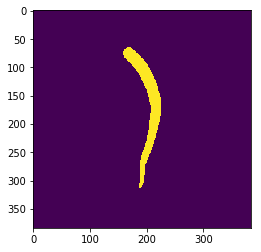

In [430]:
from sympy import *
from sympy.abc import a,b,c
import numpy as np
%matplotlib inline
from sympy import var
from rdlib2 import *
UNIT = 256
path='シルエット/17Cylindric/17kohaku1o09_l.jpg'
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
path='シルエット/17Apically/17daruma6o06_l.jpg'
path='シルエット/17Horn/17aomida1o02_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img)

In [502]:
def threeLinesSeqR3(img, showImage =  False, n_samples=20, N=5, debugmode=False, mode=5): 
    _img,contours,hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
    # バウンダリ矩形を得る
    x0,y0,w,h = cv2.boundingRect(img)
    cnt = contours[0]
    canvas = np.zeros_like(img)
    # 輪郭線の描画
    canvas = cv2.drawContours(canvas, contours, -1, 255, thickness=1)
    # 上下端それぞれ5％は歪みが大きいので一旦カット   
    cut05 = y0+int(5*h/100) # シルエッ上端から高さ5％の位置
    cut95 = y0+int(95*h/100) # シルエッ下端から高さ95％の位置

    # 仮の中心軸を決めるために左右の輪郭の近似記述を得、平均により軸の仮記述とする
    def phase1(): 
        canvas[0:cut05,:]=np.zeros((cut05,img.shape[1]))
        canvas[cut95+1:,:]=np.zeros((img.shape[0]-(cut95+1),img.shape[1]))
    
        # 輪郭検出すれば２つの輪郭が見つかるはず。
        _, contours, hierarchy = cv2.findContours(canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # 線図形の輪郭は中間で折り返しになっている
        cnt0 = contours[0][:int(len(contours[0])/2+1)]
        cnt1 = contours[1][:int(len(contours[1])/2+1)]
        # 中程の点を比べて左にある方を左と判定する。
        c0 = cnt0[int(len(cnt0)/2)][0][0]
        c1 = cnt1[int(len(cnt1)/2)][0][0]
        if  c0 > c1: 
            cntL,cntR = cnt1,cnt0
        else:
            cntR,cntL = cnt1,cnt0
        # print("左輪郭点の数 ", len(cntL),"　右輪郭点の数　", len(cntR))
        cntl = cntL[np.array(list(map(int,np.linspace(0, len(cntL)-1,n_samples))))]
        cntr = cntR[np.array(list(map(int,np.linspace(0, len(cntR)-1,n_samples))))]
        cntl = np.array([[x,y] for [[x,y]] in cntl])
        cntr = np.array([[x,y] for [[x,y]] in cntr])
        
        # 左右をそれぞれベジエ 曲線で近似し、その平均として中心軸を仮決定
        datal = cpxl,cpyl,bezXl,bezYl,tpl = fitBezierCurveN(cntl,precPara=0.01,N=N,mode=mode,debugmode=debugmode)
        # precPara=0.01,order=5,mode=5,debugmode=False
        datar = cpxr,cpyr,bezXr,bezYr,tpr = fitBezierCurveN(cntr,precPara=0.01,N=N,mode=mode,debugmode=debugmode)
        bezXc,bezYc = (bezXl+bezXr)/2,(bezYl+bezYr)/2
        ctlc = (cntl+cntr)/2 
        return cntl,cntr,ctlc,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc
    cntl,cntr,ctlc,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc = phase1()
    print('Phase1 finished')
    
        # 結果の描画
    if showImage:
        tplinsOver = np.linspace(-0.03, 1.03,55)
        tplinsLong = np.linspace(-0.3, 1.3,50)
        tplins50 = np.linspace(0, 1, 50)
        tplins20 = np.linspace(0, 1, 20)
        plt.figure(figsize=(6,6),dpi=100)
        plt.gca().invert_yaxis() 
        plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
        # 左輪郭の描画
        plotx = [bezXl.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYl.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        plt.scatter(cntl[:,0],cntl[:,1],color ='blue',marker = '.') #  サンプル点
        # plt.scatter(cpxl,cpyl,color ='purple',marker = '*') #  制御点の描画
        #for i in range(N+1):plt.annotate(str(i),(cpxl[i],cpyl[i]))
        # 右輪郭の描画
        plotx = [bezXr.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYr.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        plt.scatter(cntr[:,0],cntr[:,1],color ='blue',marker = '.') #  サンプル点
        #  plt.scatter(cpxr,cpyr,color ='red',marker = '*') #  制御点の描画
        #for i in range(N+1):plt.annotate(str(i),(cpxr[i],cpyr[i]))
        # 中心軸の描画
        plotx = [bezXc.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYc.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        
        plot20lx = [bezXl.subs(t,tp) for tp in tplins20 ]
        plot20ly = [bezYl.subs(t,tp) for tp in tplins20 ]
        plot20cx = [bezXc.subs(t,tp) for tp in tplins20 ]
        plot20cy = [bezYc.subs(t,tp) for tp in tplins20 ]
        plot20rx = [bezXr.subs(t,tp) for tp in tplins20 ]
        plot20ry = [bezYr.subs(t,tp) for tp in tplins20 ]
        
        p0,p1 = symbols('p0,p1')
        bez1 = (1-t)*p0 + t*p1
        
        for x0,x1,y0,y1 in zip(plot20lx,plot20cx,plot20ly,plot20cy):
            fx = bez1.subs([(p0,x0),(p1,x1)])
            fy = bez1.subs([(p0,y0),(p1,y1)])
            plot20x = [fx.subs(t,tp) for tp in tplins20]
            plot20y = [fy.subs(t,tp) for tp in tplins20]
            plt.plot(plot20x,plot20y,color = 'orange') 
        for x0,x1,y0,y1 in zip(plot20rx,plot20cx,plot20ry,plot20cy):
            fx = bez1.subs([(p0,x0),(p1,x1)])
            fy = bez1.subs([(p0,y0),(p1,y1)])
            plot20x = [fx.subs(t,tp) for tp in tplins20]
            plot20y = [fy.subs(t,tp) for tp in tplins20]
            plt.plot(plot20x,plot20y,color = 'orange') 

    #  得られた仮中心線を基にして輪郭上部をできるだけ軸対称になるよう左右輪郭を取り直す
    def phase2(bezXl,bezYl,bezXr,bezYr,bezXc,bezYc):
        # 得られ左右輪郭のパラメータの一致する点同士を結んだ線分をその位置での仮の幅として仮の最大幅を求める。
        max_width = 0
        max_level = 0
        levels = np.linspace(0, 1, 101)
        for lev in levels:
            xL = bezXl.subs(t,lev)
            yL = bezYl.subs(t,lev)
            xR = bezXr.subs(t,lev)
            yR = bezYr.subs(t,lev)
            w = np.sqrt(float((xL-xR)**2) + float((yL-yR)**2))
            if w > max_width:
                max_width = w
                max_level = lev
        # ループを抜けると最大幅とその時のパラメータ値が得られている。
    
        # 再び輪郭を描く
        _img,contours,hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
        x0,y0,w,h = cv2.boundingRect(img)
        cnt = contours[0]
        canvas = np.zeros_like(img)
        # 輪郭線の描画
        canvas = cv2.drawContours(canvas, contours, -1, 255, thickness=1)
        cntL,cntR = segmentLR(img,cnt,bezXc,bezYc,dmax=max_width,cutRatio=1.1,bottomcutLevel=cut95)
        return cntL,cntR
    cntL,cntR = phase2(bezXl,bezYl,bezXr,bezYr,bezXc,bezYc)
    print('Phase2 finished')
    
    # 再近似
    def phase3(cntl,cntr):
        # 左右をそれぞれ５次のベジエ 曲線で近似し、あらためて中心線と最大幅を得る。
        # リサンプリング
        cntl = cntL[np.array(list(map(int,np.linspace(0, len(cntL)-1,n_samples))))]
        cntr = cntR[np.array(list(map(int,np.linspace(0, len(cntR)-1,n_samples))))] 
        # 再ベジエ 近似
        datal = cpxl,cpyl,bezXl,bezYl,tpl = fitBezierCurveN(cntl,precPara=0.01,N=5,mode=mode,debugmode=True)
        datar = cpxr,cpyr,bezXr,bezYr,tpr = fitBezierCurveN(cntr,precPara=0.01,N=5,mode=mode,debugmode=True)
        bezXc,bezYc = (bezXl+bezXr)/2,(bezYl+bezYr)/2
        ctlc = (cntl+cntr)/2 
        # 得られ左右輪郭のパラメータの一致する点同士を結んだ線分をその位置での幅として最大幅を求める。
        max_width = 0
        max_level = 0
        lmaxP,rmaxP = np.array([0,0]),np.array([0,0])
        levels = np.linspace(0, 1, 101)
        for lev in levels:
            xL = bezXl.subs(t,lev)
            yL = bezYl.subs(t,lev)
            xR = bezXr.subs(t,lev)
            yR = bezYr.subs(t,lev)
            w = np.sqrt(float((xL-xR)**2) + float((yL-yR)**2))
            if w > max_width:
                max_width = w
                max_level = lev
                lmaxP,rmaxP = np.array([xL,yL]),np.array([xR,yR])
        # ループを抜けると最大幅とその時のパラメータ値が得られている。
        return cntl,cntr,cpxl,cpyl,cpxr,cpyr,bezXl,bezYl,bezXr,bezYr
    cntl,cntr,cpxl,cpyl,cpxr,cpyr,bezXl,bezYl,bezXr,bezYr = phase3(cntl = cntL,cntr = cntR)
    bezXc = (bezXl+bezXr)/2
    bezYc = (bezYl+bezYr)/2
    print('Phase3 finished')
    
    # 中心軸に等間隔にサンプル点を取り（２０個）、その点での法線の方程式に輪郭のベジエ 表現式を代入して５次方程式を解き、
    # 法線と左右の輪郭の交点を求める。
    def phase4(bezXc,bexYc,bexXr,bexYr,bexXl,bexYl):
        PlistL,PlistR = [],[]
        for i in np.linspace(0, 1, 20):
            y0 = bezYc.subs(t,i)
            x0 = bezXc.subs(t,i)
            dx = diff(bezXc,t).subs(t,i) # x、y をそれぞれ t で微分　傾きを求めようとしている
            dy = diff(bezYc,t).subs(t,i)
            ans = solve(-dx/dy*(bezXr-x0)+y0-bezYr,t) # 法線とベジエ輪郭の交点を求める
            s = [i for i in ans if im(i)==0 and i<=1.2 and -0.2<=i]
            PlistR.append(s)
        for i in np.linspace(0, 1, 20):
            y0 = bezYc.subs(t,i)
            x0 = bezXc.subs(t,i)
            dx = diff(bezXc,t).subs(t,i) # x、y をそれぞれ t で微分　傾きを求めようとしている
            dy = diff(bezYc,t).subs(t,i)
            ans = solve(-dx/dy*(bezXl-x0)+y0-bezYl,t) # 法線とベジエ輪郭の交点を求める
            s = [i for i in ans if im(i)==0 and i<=1.2 and -0.2<=i]
            PlistL.append(s)

        # 定積分により軸に沿った長さを求める
        dxdt = diff(bezXc,t)
        dydt = diff(bezYc,t)
        leng = integrate(sqrt(dxdt**2+dydt**2),(t,0,s))
        radiusTable = []
        for i, tpara in enumerate(np.linspace(0,1,20)):
            len = float(leng.subs(s,tpara)) # 上端からの長さ
            radishR = float((PlistL[i][0]+PlistR[i][0])/2) # 太さ
            radiusList.append([len,radishR]) 
    
        #結果の描画
        if True:
            tplins50 = np.linspace(0, 1, 50)
            tplins20 = np.linspace(0, 1, 20)
            plt.figure(figsize=(6,6),dpi=100)
            plt.gca().invert_yaxis() 
            plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
            # 左輪郭の描画
            plotx = [bezXl.subs(t,tp) for tp in tplins50 ]
            ploty = [bezYl.subs(t,tp) for tp in tplins50 ]
            plt.plot(plotx,ploty,color = 'red')  
            # plt.scatter(cntl[:,0],cntl[:,1],color ='blue',marker = '.') #  サンプル点
            plt.scatter(cpxl,cpyl,color ='purple',marker = '*') #  制御点の描画
            for i in range(N+1):plt.annotate(str(i),(cpxl[i],cpyl[i]))

            # 右輪郭の描画
            plotx = [bezXr.subs(t,tp) for tp in tplins50 ]
            ploty = [bezYr.subs(t,tp) for tp in tplins50 ]
            plt.plot(plotx,ploty,color = 'red')  
            plt.scatter(cntr[:,0],cntr[:,1],color ='blue',marker = '.') #  サンプル点
            plt.scatter(cpxr,cpyr,color ='red',marker = '*') #  制御点の描画
            for i in range(N+1):plt.annotate(str(i),(cpxr[i],cpyr[i]))
            # 中心軸の描画
            plotx = [bezXc.subs(t,tp) for tp in tplins50 ]
            ploty = [bezYc.subs(t,tp) for tp in tplins50 ]
            plt.plot(plotx,ploty,color = 'red')  
        
            # 幅線の描画
            plot20lx = [bezXl.subs(t,tp[0]) if tp !=[] else [] for tp in PlistL ]
            plot20ly = [bezYl.subs(t,tp[0]) if tp !=[] else [] for tp in PlistL]
            plot20cx = [bezXc.subs(t,tp) for tp in np.linspace(0, 1, 20) ]
            plot20cy = [bezYc.subs(t,tp) for tp in np.linspace(0, 1, 20) ]
            plot20rx = [bezXr.subs(t,tp[0]) if tp !=[] else [] for tp in PlistR ]
            plot20ry = [bezYr.subs(t,tp[0]) if tp !=[] else [] for tp in PlistR ]
        
            # 内分点の定義式（１次のベジエ ）
            p0,p1 = symbols('p0,p1')
            bez1 = (1-t)*p0 + t*p1
        
            for x0,x1,y0,y1 in zip(plot20lx,plot20cx,plot20ly,plot20cy):
                if x0 != [] and y0 !=[]:
                    fx = bez1.subs([(p0,x0),(p1,x1)])
                    fy = bez1.subs([(p0,y0),(p1,y1)])
                    plot20x = [fx.subs(t,tp) for tp in tplins20]
                    plot20y = [fy.subs(t,tp) for tp in tplins20]
                    plt.plot(plot20x,plot20y,color = 'orange') 
            for x0,x1,y0,y1 in zip(plot20rx,plot20cx,plot20ry,plot20cy):
                if x0 != [] and y0 !=[]:
                    fx = bez1.subs([(p0,x0),(p1,x1)])
                    fy = bez1.subs([(p0,y0),(p1,y1)])
                    plot20x = [fx.subs(t,tp) for tp in tplins20]
                    plot20y = [fy.subs(t,tp) for tp in tplins20]
                    plt.plot(plot20x,plot20y,color = 'orange') 
                
    return cntl,cntr,cpxl,cpyl,cpxr,cpyr,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc,radiusList
            
# 中心軸情報をもとに輪郭データを左右に分ける
def segmentLR(img,cnt,bezX,bezY,dmax,cutRatio=1.1,bottomcutLevel = 10):
    # あらためて概形画像から輪郭線を抽出
    #  img 画像 サイズの参照だけ
    # bezX,bezY 中心軸近似ベジエ曲線
    # dmax 最大直径
    # tcutRatio上部を削るために描く円の半径に掛ける倍率
    # bottomcutRadius　下部を削るために描く円の半径
    
    # 輪郭線の描画
    canvas = np.zeros_like(img)
    canvas = cv2.drawContours(canvas, cnt, -1, 255, thickness=1)
    # 中心軸の延長で上端から最大半径離れた地点を中心に最大半径より少し大きな円を０で描き輪郭を削る。
    dx = float(diff(bezX,t).subs(t,0.08)) # t=0 は境界なので変な値にあることがあるため 0.08 としている
    dy = float(diff(bezY,t).subs(t,0.08))
    acc = dy/dx if dx != 0 else np.inf
    nom = -dx/dy if dy != 0 else np.inf
    x00 = bezX.subs(t,0) #  軸の再上端
    y00 = bezY.subs(t,0)
    print(x00,y00,dx,dy,acc) 
    if acc == 0:
        if bezX.subs(s,1) > x00:
            xdd = dmax/2
        else:
            xdd = -dmax/2
    else:
        xdd = -dmax/2/acc
    x11 = x00+xdd 
    y11 = y00+xdd*acc if acc != 0 else y00
    y11 = y00-dmax/2 if dx*dx < 0.0001 else y11
    dia = int(dmax/2*cutRatio) # int(np.sqrt(float((x00-x11)**2+(y00-y11)**2)))
    canvas =  cv2.circle(canvas,(int(x11),int(y11)),dia,0,-1)
    # 下端を削る
    canvas[bottomcutLevel+1:,:]=np.zeros((img.shape[0]-(bottomcutLevel+1),img.shape[1])) 
        
    plt.figure(figsize=(6,6),dpi=100)    
    plt.imshow(canvas)
    
    # 輪郭検出すれば２つの輪郭が見つかるはず。
    _, contours, hierarchy = cv2.findContours(canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 線図形の輪郭は中間で折り返しになっている
    cnt0 = contours[0][:int(len(contours[0])/2+1)]
    cnt1 = contours[1][:int(len(contours[1])/2+1)]
    # 中程の点を比べて左にある方を左と判定する。
    c0 = cnt0[int(len(cnt0)/2)][0][0]
    c1 = cnt1[int(len(cnt1)/2)][0][0]
    if  c0 > c1: 
        cntL,cntR = cnt1,cnt0
    else:
        cntR,cntL = cnt1,cnt0
    print("左輪郭点の数 ", len(cntL),"　右輪郭点の数　", len(cntR))
    #  ２重かっこを１重に変換し、numpy array にしてから返す
    cntL = np.array([[x,y] for [[x,y]] in cntL])
    cntR = np.array([[x,y] for [[x,y]] in cntR])                
    return cntL,cntR

Phase1 finished
172.576318754321 78.3179177433731 142.78149920557055 185.09149170166165 1.2963268541898065
左輪郭点の数  222 　右輪郭点の数　 233
Phase2 finished
diffpara 0.02460884675383576
diffpara 0.0
diffpara 0.02074750512838372
diffpara 0.004999995231628418
Phase3 finished


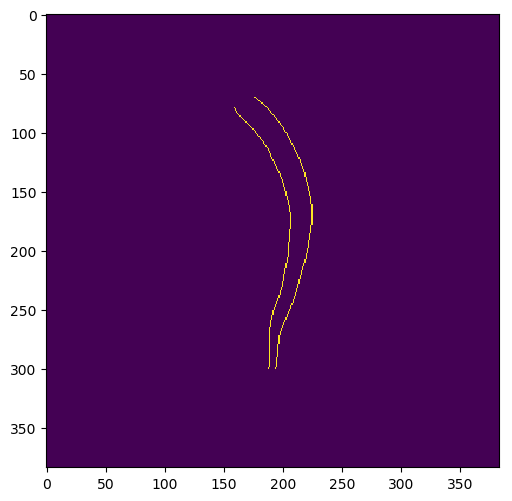

In [503]:
cntl,cntr,max_width,lmaxP,rmaxP  = threeLinesSeqR3(img, showImage =True, n_samples=20, N=5, debugmode=False, mode=4)

In [504]:
# 最大幅位置での分割近似
def phase4(cntl,cntr,max_width,lmaxP,rmaxP):
        differ = cntl-lmaxP
        distance = [x*x+y*y for x,y in differ] # 自乗誤差の配列
        d_index = np.argmin(distance)
        print(distance,d_index)
phase4(cntl,cntr,max_width,lmaxP,rmaxP)

[1250.62521732851, 1152.99403617381, 1101.74478231574, 1010.11360116104, 962.864347302979, 877.233166148277, 795.601984993574, 717.970803838871, 644.339622684169, 574.708441529466, 509.077260374764, 447.446079220061, 389.814898065358, 336.183716910656, 286.552535755953, 240.921354601250, 199.290173446548, 161.658992291845, 128.027811137143, 98.3966299824399, 72.7654488277373, 59.5161949696749, 39.8850138149723, 24.2538326602696, 12.6226515055670, 4.99147035086438, 1.74221649280199, 0.111035338099356, 2.47985418339672, 8.84867302869409, 13.5994191706317, 25.9682380159291, 42.3370568612264, 53.0878030031641, 75.4566218484614, 101.825440693759, 118.576186835696, 150.945005680994, 171.695751822931, 210.064570668229, 234.815316810166, 261.566062952104, 307.934881797401, 338.685627939339, 391.054446784636, 425.805192926574, 484.174011771871, 522.924757913809, 587.293576759106, 630.044322901044, 700.413141746341, 747.163887888279, 823.532706733576, 874.283452875514, 956.652271720811, 1011.403

In [505]:
cntl

array([[159,  79],
       [160,  80],
       [160,  81],
       [161,  82],
       [161,  83],
       [162,  84],
       [163,  85],
       [164,  86],
       [165,  87],
       [166,  88],
       [167,  89],
       [168,  90],
       [169,  91],
       [170,  92],
       [171,  93],
       [172,  94],
       [173,  95],
       [174,  96],
       [175,  97],
       [176,  98],
       [177,  99],
       [177, 100],
       [178, 101],
       [179, 102],
       [180, 103],
       [181, 104],
       [181, 105],
       [182, 106],
       [183, 107],
       [184, 108],
       [184, 109],
       [185, 110],
       [186, 111],
       [186, 112],
       [187, 113],
       [188, 114],
       [188, 115],
       [189, 116],
       [189, 117],
       [190, 118],
       [190, 119],
       [190, 120],
       [191, 121],
       [191, 122],
       [192, 123],
       [192, 124],
       [193, 125],
       [193, 126],
       [194, 127],
       [194, 128],
       [195, 129],
       [195, 130],
       [196,

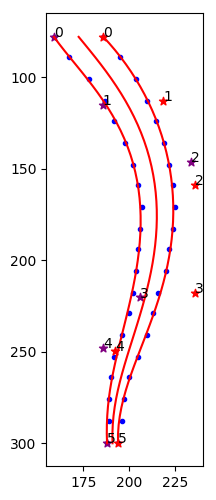

In [434]:
threeLinesSeqR2(img, showImage =  False, n_samples=20,N=5)

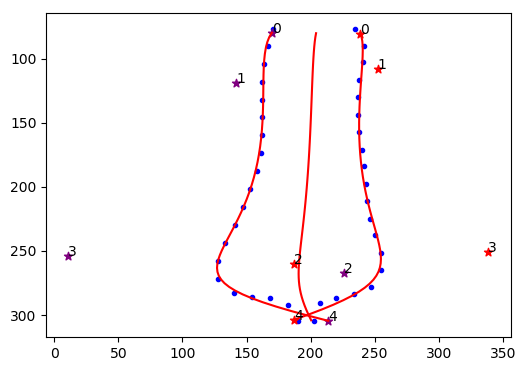

In [344]:
threeLinesSeqR2(img, showImage =  False, n_samples=20,N=4)

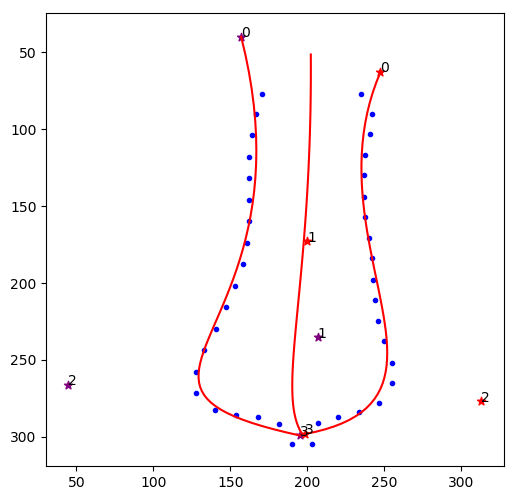

In [345]:
threeLinesSeqR2(img, showImage =  False, n_samples=20,N=3)

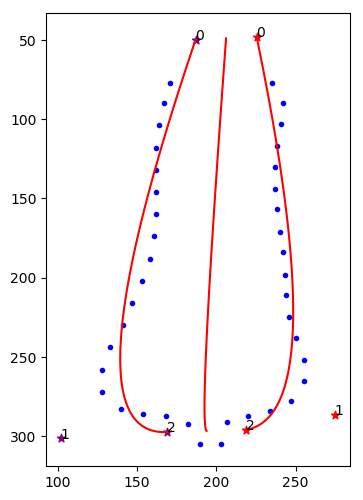

In [346]:
threeLinesSeqR2(img, showImage =  False, n_samples=20,N=2)

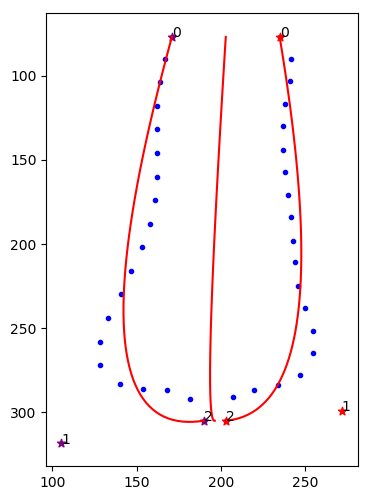

In [349]:
threeLinesSeqR2(img, showImage =  False, n_samples=20,N=2,mode=2)

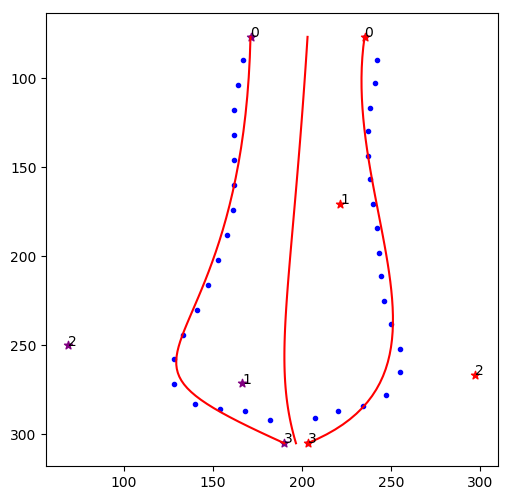

In [353]:
threeLinesSeqR2(img, showImage =  False, n_samples=20,N=3,mode=2)

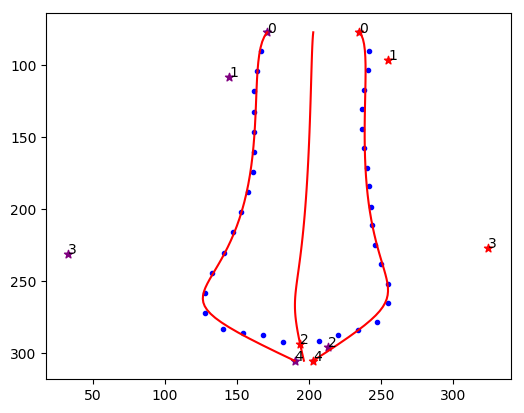

In [351]:
threeLinesSeqR2(img, showImage =  False, n_samples=20,N=4,mode=2)

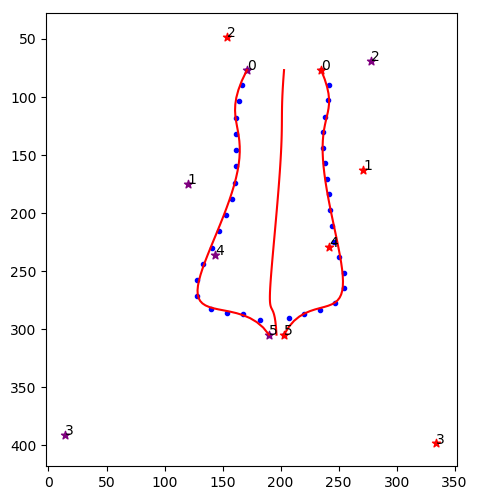

In [352]:
threeLinesSeqR2(img, showImage =  False, n_samples=20,N=5,mode=2)